# VQE H3 e H3+


### Note:
* Non imposto esplicitamente lo spin... cosa ne fa?
* Uso la base sto3g, ma potrei anche cambiarla magari
* Uso un operatore fermionico, ma non so bene cosa sia (così come anzhe le Z2Summetries)
* Su wikipedia vedo una distanza di 0.9 A, io ne calcolo una minima di 1
* Qubit mapping:
    * Parity
    * Jordan Wigner
    * Altro

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import Aer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.chemistry import QiskitChemistryError
from qiskit.chemistry.applications import MolecularGroundStateEnergy
from qiskit.chemistry.algorithms import ground_state_solvers
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.core import QubitMappingType
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType

/home/rodolfo/venv/myqiskit/lib/python3.8/site-packages/pyscf/lib/misc.py:47: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [2]:
# Ottengo dei warnings perchè uso deprecated functions, così li evito un po' bruscamente
import warnings
warnings.filterwarnings("ignore")

In [3]:
#charge 0 e spin 1 -> H3 spin 3, prob
#charge 1 e spin 0 -> H3+ spin 0? per la regola di hund si disporranno entrambi up -> 2*(1/2+1/2) = 2, invece sembra essere 0

#lo spin è 2S per come viene definita la molecola (non 2S+1)

def get_driver(dist):
    charge = 1
    spin = 0
    alt=np.sqrt(dist**2 - (dist/2)**2)
    driver = PySCFDriver(atom="H .0 .0 .0; H .0 .0 " + str(dist) + "; H .0 " + str(alt) + " " + str(dist/2),
                         unit=UnitsType.ANGSTROM, spin = spin,
                         charge=charge, basis='sto3g')
    return driver

In [4]:
def get_qubit_op(dist):
    driver = get_driver(dist)
    molecule = driver.run()
    
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    qubitOp = ferOp.mapping(map_type='jordan_wigner')
    shift =  repulsion_energy
    return qubitOp
    #return qubitOp, num_particles, num_spin_orbitals, shift

Restituisce vqe, ovvero? Da analizzare per bene
* Qubit Mapping type:
    * JORDAN_WIGNER
    * PARITY
    * BRAVYI_KITAEV

In [15]:
def cb_create_solver(num_particles, num_orbitals,
                        qubit_mapping, two_qubit_reduction, z2_symmetries):
    initial_state = HartreeFock(num_orbitals, num_particles, qubit_mapping,
                                two_qubit_reduction, z2_symmetries.sq_list)
    var_form = UCCSD(num_orbitals=num_orbitals,
                        num_particles=num_particles,
                        initial_state=initial_state,
                        qubit_mapping=qubit_mapping,
                        two_qubit_reduction=two_qubit_reduction,
                        z2_symmetries=z2_symmetries)
    #print("NUMERO PARAMETRI: " + str(var_form.num_parameters)) 8
    
    #print(var_form.num_qubits) # in questo momento la varform usa 6 qubits
    vqe = VQE(operator = get_qubit_op(dist), 
              var_form=var_form, optimizer=SLSQP(maxiter=500), include_custom=True)
    #vqe = VQE(var_form=var_form, optimizer=SLSQP(maxiter=500), include_custom=True)
    #vqe.compute_minimum_eigenvalue()
    vqe.quantum_instance = Aer.get_backend('qasm_simulator')
    vqe.run()
    circuit = vqe.get_optimal_circuit()
    circuit.draw(output='mpl', filename='my_circuit.png')
    print(vqe.optimal_params)
    return vqe

In [16]:
distances = np.arange(0.8, 0.9, 0.2)
vqe_energies = []
min = 100.0
dismin = 0.0

for dist in distances:
    print("Calcolo distanza: "+str(dist))
    driver = get_driver(dist)
    mgse = MolecularGroundStateEnergy(driver, 
                                  qubit_mapping=QubitMappingType.JORDAN_WIGNER,
                                  two_qubit_reduction=False, freeze_core=False,
                                  z2symmetry_reduction=None)
    result = mgse.compute_energy(cb_create_solver)
    try:
        result = mgse.compute_energy(cb_create_solver)
        vqe_energies.append(result.energy)
        print("\tEnergia: " +str(result.energy))
        if result.energy < min:
            min = result.energy
            dismin = dist
    except:
        print("errore")
        vqe_energies.append(min)

print("Energia minima a " + str(dismin) + " A: " + str(min) + " eV")

Calcolo distanza: 0.8
[-9.80155572e-06  2.92505913e-06 -9.68237679e-06  2.89102150e-06
 -7.77858746e-02  3.14193715e-08  3.85530947e-08 -7.80439449e-02]
[-9.71261404e-06  3.05378378e-06 -9.66527761e-06  3.12806797e-06
 -7.77858846e-02 -3.87711388e-08 -3.16379495e-08 -7.80439480e-02]
	Energia: -1.23572577848417
Energia minima a 0.8 A: -1.23572577848417 eV


Inizialmente avevo anche una soluzione con il numpy eigensolver, ma non va bene
https://github.com/Qiskit/qiskit-aqua/issues/1162
Hi, when the 2nd quantized Hamiltonian is built out, since it has one and two- body creation and annihilation operators in its formation, we end up with states in the Hamiltonian for every possible particle configuration. The lowest eigenvalue in that Hamiltonian, ends up being the state with those atoms where the particle configuration (from none, to fully occupied) gives that lowest energy - this may NOT be the configuration you have entered. The NumPyEigensolver just gives the lowest energy period.

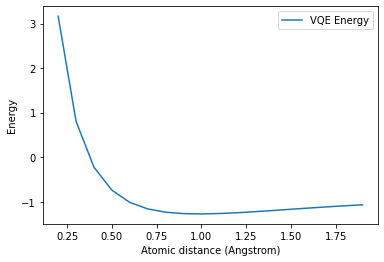

In [94]:
#plt.plot(distances, exact_energies, label="Numpy Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
#plt.ylim([-1.5, -1.3])
plt.show()

Viene letto il file file.txt contenente energie e distanze già calcolate, se sonos tate analizzate nuove distanze le scrive in append alla fine.

In [90]:
with open('file.txt') as f:
    #w, h = [int(x) for x in next(f).split()] # read first line
    distanze_energie = []
    for line in f: # read rest of lines
        w,h=[float(x) for x in line.split()]
        distanze_energie.append((w,h))
f=open('file.txt', 'w+')
i = -1
for dist in distances:
    i=i+1
    if (dist,vqe_energies[i]) not in distanze_energie:
        distanze_energie.append((dist, vqe_energies[i]))
distanze_energie.sort(key=lambda pair: pair[0])
for i in distanze_energie:
    f.write(str(i[0]) + " " + str(i[1]) + "\n")
f.close()

Viene disegnato il grafico di quanto presente nel file file.txt

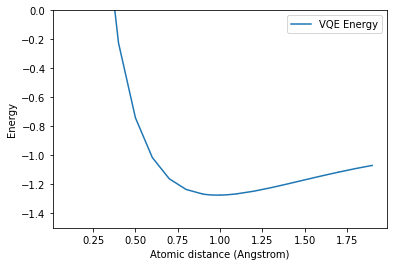

In [93]:
f=open('file.txt')
    #w, h = [int(x) for x in next(f).split()] # read first line
distanze = []
energie = []
for line in f: # read rest of lines
    w,h=[float(x) for x in line.split()]
    distanze.append(w)
    energie.append(h) 
plt.plot(distanze, energie, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.ylim([-1.5, -0])
plt.show()

In [98]:
3*1.27

3.81

In [120]:
get_driver(0.9) 


Total count for 00 and 11 are: {'00': 506, '11': 494}


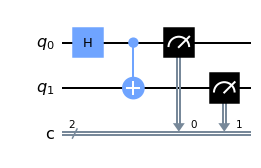

In [12]:
import numpy as np
from qiskit import(
  QuantumCircuit,
  execute,
  Aer)
from qiskit.visualization import plot_histogram

# Use Aer's qasm_simulator
simulator = Aer.get_backend('qasm_simulator')

# Create a Quantum Circuit acting on the q register
circuit = QuantumCircuit(2, 2)

# Add a H gate on qubit 0
circuit.h(0)

# Add a CX (CNOT) gate on control qubit 0 and target qubit 1
circuit.cx(0, 1)

# Map the quantum measurement to the classical bits
circuit.measure([0,1], [0,1])

# Execute the circuit on the qasm simulator
job = execute(circuit, simulator, shots=1000)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(circuit)
print("\nTotal count for 00 and 11 are:",counts)

# Draw the circuit
circuit.draw(output='mpl')